# Time Series Analysis 

This notebook analyze the **weekly lithium future log_return** using **ARIMA and GARCH** model.

**Before Modeling:**
Resampling, Transform data

**Modeling Steps:**

1) Build ARIMA model for lithium future price based on serial dependence revealed by the ACF and PACF;

2) Test the residuals of the model for ARCH/GARCH effects, relying on ACF and PACF of squared residual;

3) Specify a volatility model if serial correlation effects are significant and jointly estimate the mean and volatility equations

4) Evaluate if residuals is white noise (if it is, stop; otherwise, tune the model)

**Conclusion:**

Log_return -> **ARIMA(1,0,2)** -> **GARCH(1,1)** -> White Noise 

In above chain, every step remove the effect, and output the residuals to next step. 

In conclusion, main effects include autocorrelation and volatility effect could be removed with ARIMA(1,0,2) and GARCH(1,1). 



In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import io

## import library 
import warnings
warnings.filterwarnings('ignore')

In [74]:
import statsmodels.api as sm


In [70]:
def transform_data(file_path): 
    
    '''
    This function transform the price into log return and output the weekly log return and price in a dataframe.
    '''

    outlier_cutoff = 0.01
    # read the data
    price = pd.read_csv(file_path)

    # print or inspect the DataFrame before renaming the columns
    print(price.head())

    # ask for the column names 
    column_names = input("Please enter the column names, separated by a comma: ").split(',')

    # strip any leading/trailing whitespace from the column names
    column_names = [name.strip() for name in column_names]

    # rename the columns 
    price.columns = column_names

    # transfer the date to date format 
    price['Date'] = pd.to_datetime(price['Date'])
    
    if (price['Price'].apply(type) == str).any():
        price['Price'] = price['Price'].str.replace(',', '', regex=True).astype(float)
    price.set_index('Date', inplace=True)

    # Resample to get the last business day's 'Close' price for each week.
    # 'W-FRI' denotes weeks ending on Friday.
    weekly_price = price['Price'].resample('W-FRI').last()

    # make the series a dataframe:
    weekly_price = pd.DataFrame(weekly_price)

    # Calculate log returns
    weekly_price['Log_Return'] = np.log(weekly_price["Price"]).diff().\
    pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_price = weekly_price.dropna()

    return weekly_price

def plot_correlogram(x, lags=None, title=None):
    '''
    Plot the series, QQ plot, ACF, PACF
    '''
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Series(residuals)')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        
        plot_acf(x=x, lags=lags, ax=axes[1][0])
        plot_pacf(x, lags=lags, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)
        
def ARIMA_Model_Fit(series, p,d,q, title):
    '''
    Fit the ARIMA model and output the residual of the model 
    '''
    plot_correlogram(series, lags = 50, title = "Before Modeling: " + title)
    model_price = tsa.ARIMA(series,order=(p,d,q)).fit()
    print(model_price.summary())
    plot_correlogram(model_price.resid, lags = 50, title = "After Modeling: "+ title)
    return model_price.resid

## Getting Data

In [3]:
weekly_future_price = transform_data("Lithium futures price.csv")

         Date      Open      High       Low     Close  Change %  Volume
0  2017-05-10  136000.0  140000.0  132000.0  136000.0       0.0       0
1  2017-05-11  136000.0  140000.0  132000.0  136000.0       0.0       0
2  2017-05-12  136000.0  140000.0  132000.0  136000.0       0.0       0
3  2017-05-15  136000.0  140000.0  132000.0  136000.0       0.0       0
4  2017-05-16  136000.0  140000.0  132000.0  136000.0       0.0       0


Please enter the column names, separated by a comma:  Date,Open,High,Low,Price, Change, Vol


## ARIMA Model (ACF and PACF)

                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                  299
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 673.654
Date:                Thu, 27 Jul 2023   AIC                          -1337.309
Time:                        01:19:09   BIC                          -1318.807
Sample:                             0   HQIC                         -1329.903
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.007      0.360      0.719      -0.011       0.017
ar.L1          0.8619      0.031     27.563      0.000       0.801       0.923
ma.L1         -0.3716      0.041     -9.071      0.0

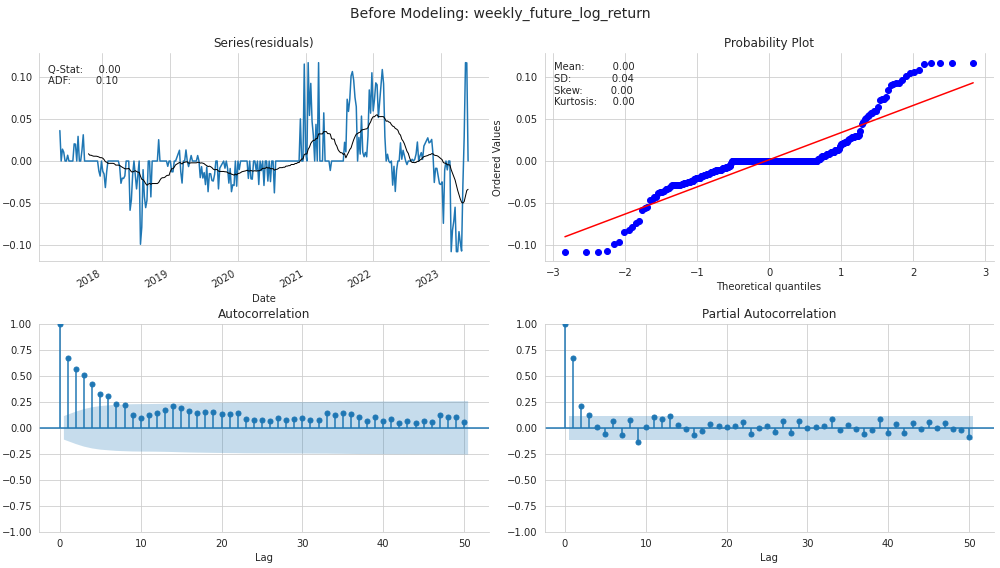

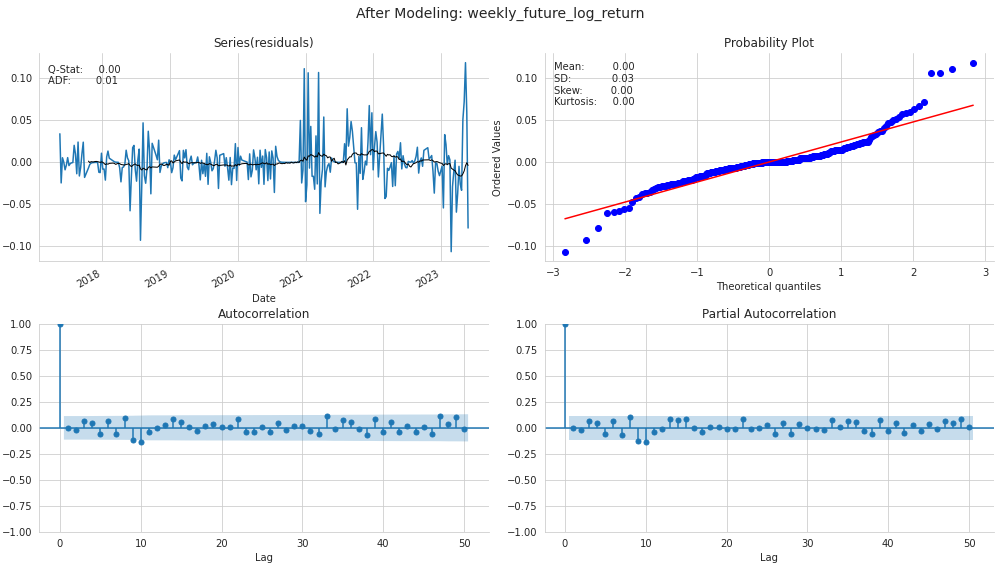

In [71]:
# fit the model with ARIMA(1,0,2)
model_resid_future_price = ARIMA_Model_Fit(weekly_future_price['Log_Return'], 1,0,2, title = "weekly_future_log_return")

## Detecting Volatility Effect

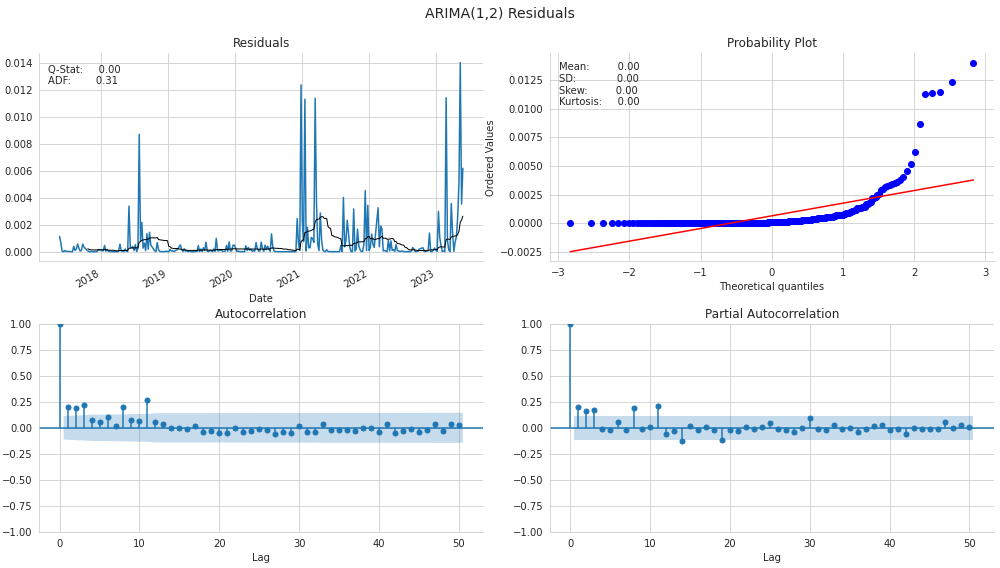

In [58]:
plot_correlogram(model_resid_future_price.sub(model_resid_future_price.mean()).pow(2), lags=50, title='ARIMA(1,2) Residuals')

## GARCH Model 

In [60]:
## Find the best model: 
trainsize = 100  # 10 years
data = model_resid_future_price.clip(lower=model_resid_future_price.quantile(.05),
                           upper=model_resid_future_price.quantile(.95))
T = len(model_resid_future_price)
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4


/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2 | 1
2 | 2
2 | 3


/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2 | 4


/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


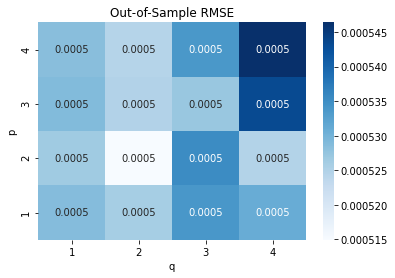

In [62]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

In [63]:
best_p, best_q = 1, 1

In [65]:
am = ConstantMean(model_resid_future_price.clip(lower=model_resid_future_price.quantile(.05),
                                      upper=model_resid_future_price.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 1833684581341502.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -804.8299676160982
            Iterations: 13
            Function evaluations: 84
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                804.830
Distribution:                  Normal   AIC:                          -1601.66
Method:            Maximum Likelihood   BIC:                          -1586.86
                                        No. Observations:                  299
Date:                Thu, Jul 27 2023   Df Residuals:                      298
Time:                        01:05:01   Df Model:                            1
       

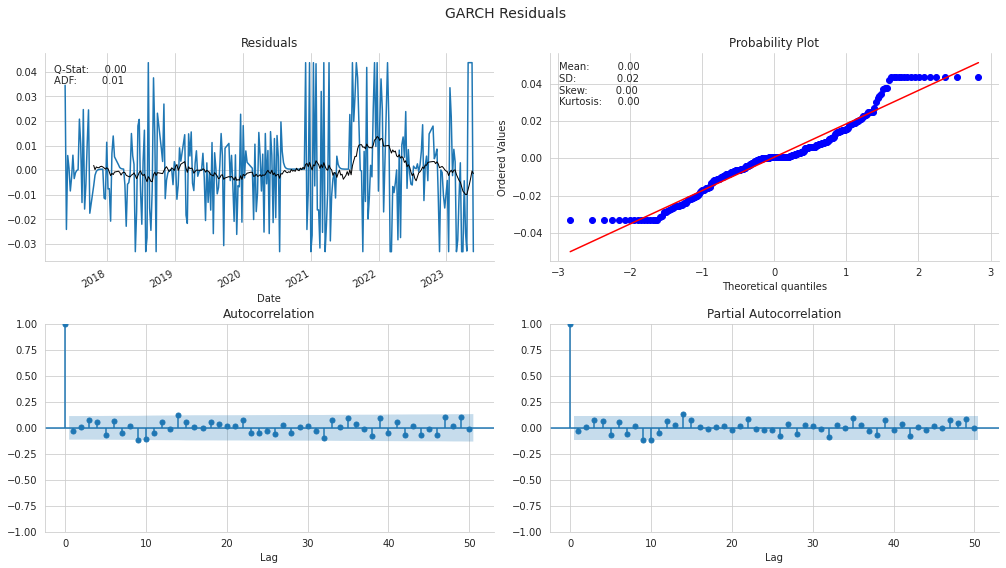

In [66]:
plot_correlogram(best_model.resid.dropna(),
                 lags=50,
                 title='GARCH Residuals')

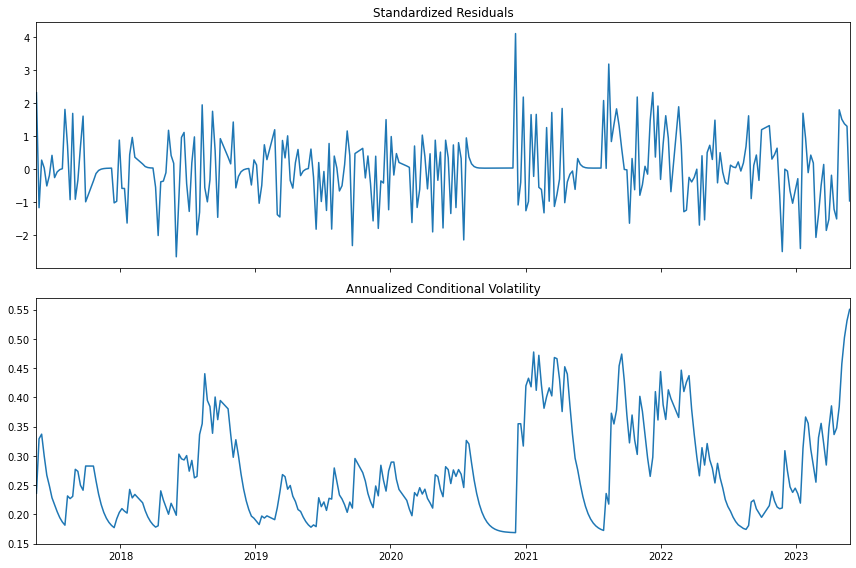

In [67]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

## Evaluate Residual (White Noise Test)

According to the p_values, the residual is white noise.

In [86]:
# Ljung Box Test H0: White Noise, H1: not White Noise
sm.stats.acorr_ljungbox(best_model.resid, lags = range(1,10))

,lb_stat,lb_pvalue
1,0.225679,0.634746
2,0.250963,0.882072
3,1.796533,0.615690
4,2.793241,0.593000
5,4.128925,0.531007
6,5.378148,0.496305
7,6.174751,0.519499
8,6.292192,0.614538
9,10.590984,0.304789
